<a href="https://colab.research.google.com/github/tsai-praveen/era1-assignments/blob/main/S5/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from model import Net
from utils import GetCorrectPredCount, train, test, plot_stats

CODE BLOCK: 2

In [8]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [9]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [10]:
train_data = datasets.MNIST('data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [11]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

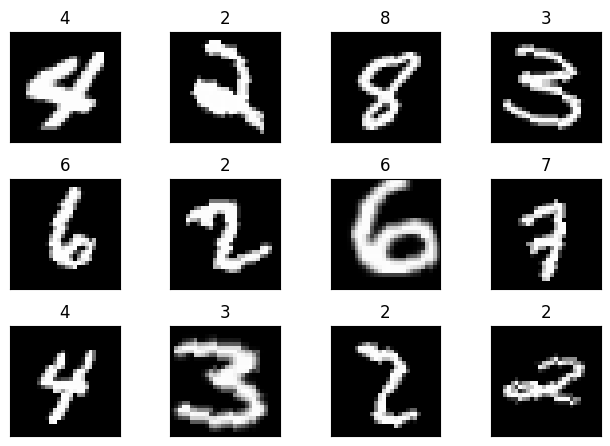

In [12]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [13]:
# class Net(nn.Module):
#     #This defines the structure of the NN.
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x), 2)
#         x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
#         x = F.relu(self.conv3(x), 2)
#         x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [15]:

# from tqdm import tqdm

# def GetCorrectPredCount(pPrediction, pLabels):
#   return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# def train(model, device, train_loader, optimizer, criterion):
#   model.train()
#   pbar = tqdm(train_loader)

#   train_loss = 0
#   correct = 0
#   processed = 0

#   for batch_idx, (data, target) in enumerate(pbar):
#     data, target = data.to(device), target.to(device)
#     optimizer.zero_grad()

#     # Predict
#     pred = model(data)

#     # Calculate loss
#     loss = criterion(pred, target)
#     train_loss+=loss.item()

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
    
#     correct += GetCorrectPredCount(pred, target)
#     processed += len(data)

#     pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

#   train_acc.append(100*correct/processed)
#   train_losses.append(train_loss/len(train_loader))

# def test(model, device, test_loader, criterion):
#     model.eval()

#     test_loss = 0
#     correct = 0

#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_loader):
#             data, target = data.to(device), target.to(device)

#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

#             correct += GetCorrectPredCount(output, target)


#     test_loss /= len(test_loader.dataset)
#     test_acc.append(100. * correct / len(test_loader.dataset))
#     test_losses.append(test_loss)

#     print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
     

In [16]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 10

In [18]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion_train = nn.CrossEntropyLoss() 
criterion_test = nn.CrossEntropyLoss(reduction='sum')

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  tr_acc, tr_loss = train(model, device, train_loader, optimizer, criterion_train)
  train_acc.append(tr_acc)
  train_losses.append(tr_loss)

  te_acc, te_loss = test(model, device, test_loader, criterion_test)
  test_acc.append(te_acc)
  test_losses.append(te_loss)

  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.7984 Batch_id=117 Accuracy=23.27: 100%|██████████| 118/118 [00:34<00:00,  3.42it/s]


Test set: Average loss: 1.7171, Accuracy: 4974/10000 (49.74%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.4668 Batch_id=117 Accuracy=84.58: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.1656, Accuracy: 9480/10000 (94.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2431 Batch_id=117 Accuracy=94.16: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Test set: Average loss: 0.0986, Accuracy: 9713/10000 (97.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0734 Batch_id=117 Accuracy=95.89: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0699, Accuracy: 9773/10000 (97.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0832 Batch_id=117 Accuracy=96.72: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s]


Test set: Average loss: 0.0539, Accuracy: 9829/10000 (98.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0727 Batch_id=117 Accuracy=97.07: 100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


Test set: Average loss: 0.0462, Accuracy: 9852/10000 (98.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0786 Batch_id=117 Accuracy=97.56: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0450, Accuracy: 9862/10000 (98.62%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0302 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0545, Accuracy: 9827/10000 (98.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0964 Batch_id=117 Accuracy=97.82: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


Test set: Average loss: 0.0389, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1186 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0355, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0437 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Test set: Average loss: 0.0313, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0313 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0317, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0407 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0292, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0855 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Test set: Average loss: 0.0264, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0142 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0273, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0161 Batch_id=117 Accuracy=98.85: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s]


Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0997 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0302 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0481 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s]


Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0220 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

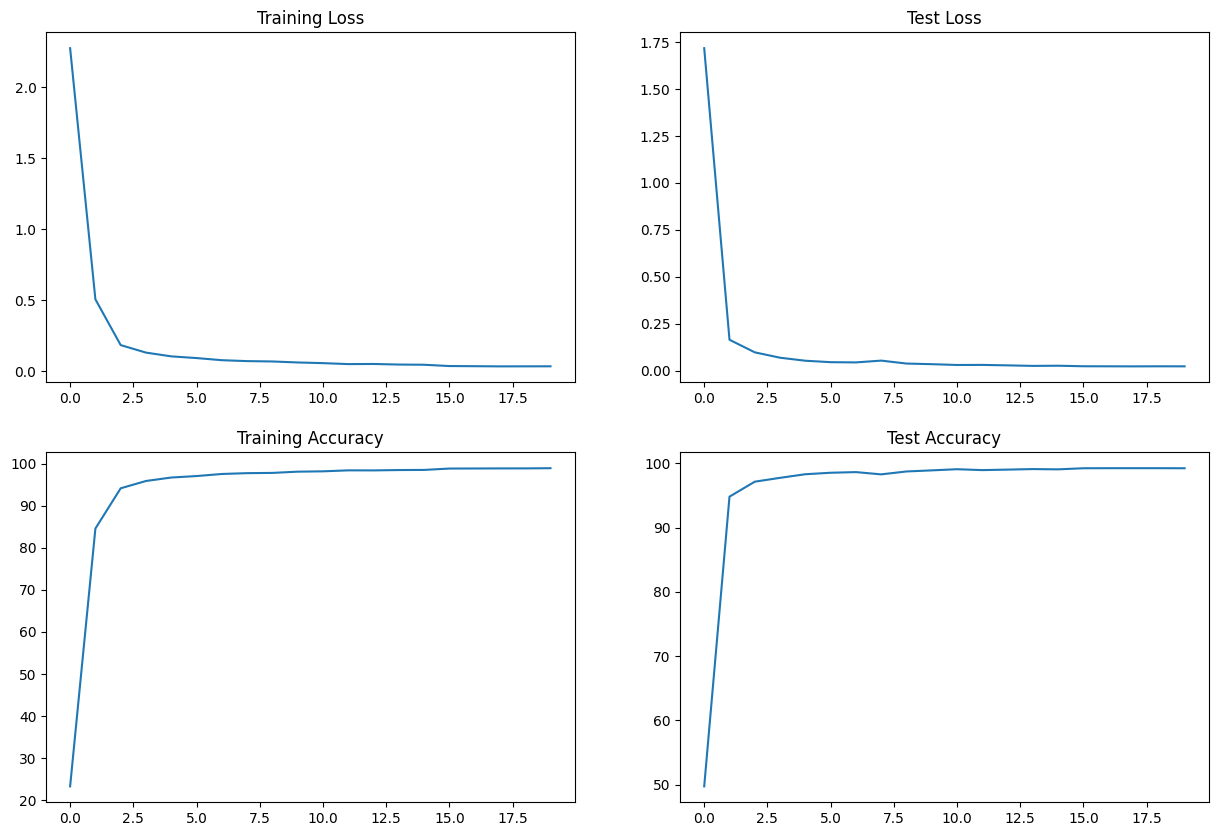

In [19]:
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")

plot_stats(train_losses, train_acc, test_losses, test_acc)